# Estimación de calor en una placa metálica

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Paso 0: Generación de la malla y funciones de los bordes

In [2]:
# Longitud de la placa de calor
n = 10

# Resolución de la malla
r = 50

# Bordes de la placa (cuadrada)
points = np.linspace(0, n, r + 2)

# Placa
eje_x, eje_y = np.meshgrid(points, points)

In [3]:
# Funciones de los bordes
F1 = lambda x: 10*np.sin(x)
G1 = lambda x: np.cos(x)
F2 = lambda x: 20*(np.sin(x)**2)
G2 = lambda x: 20*(np.cos(x)**2)

## Paso 1: Matriz A y vector b

In [4]:
t = np.array([F2(x) for x in points])
w = np.array([F1(x) for x in points])  
u = np.array([G1(y) for y in points])  
s = np.array([G2(y) for y in points]) 

In [5]:
def llenaAb(A, b, i):
    # Caso 1
    if i == 0:
        A[i, i] = 4
        A[i, i+1] = -1
        A[i, r+i] = -1
        b[i] = t[i+1] + u[1]

    # Caso 2
    elif i in range(1, r-1):
        A[i, i] = 4
        A[i, i-1] = -1
        A[i, i+1] = -1
        A[i, r+i] = -1
        b[i] = t[i+1]

    # Caso 3
    elif i == r-1:
        A[i, i] = 4
        A[i, i-1] = -1
        A[i, r+i] = -1
        b[i] = t[i+1] + s[1]

    # Caso 4
    elif i in range(r, r**2 - r, r):
        A[i, i] = 4
        A[i, i+1] = -1
        A[i, r+i] = -1
        A[i, i-r] = -1
        b[i] = u[(i//r) + 1]

    # Caso 6
    elif i in range(2*r - 1, r**2 - r, r):
        A[i, i] = 4
        A[i, i-1] = -1
        A[i, r+i] = -1
        A[i, i-r] = -1
        b[i] = s[((i+1)//r) + 1]

    # Caso 7
    elif i == r**2 - r:
        A[i, i] = 4
        A[i, i+1] = -1
        A[i, i-r] = -1
        b[i] = u[2] + w[1]

    # Caso 8
    elif i in range(r**2 - r + 1, r**2, r):
        A[i, i] = 4
        A[i, i-1] = -1
        A[i, i+1] = -1
        A[i, i-r] = -1
        b[i] = w[(((i-1)//r) + 1)//r + 1]

    # Caso 9
    elif i == r**2-1:
        A[i, i] = 4
        A[i, i-1] = -1
        A[i, i-r] = -1
        b[i] = w[-2] + s[-2]
        
    # Caso 5
    else:
        try:
            A[i, i] = 4
            A[i, i+1] = -1
            A[i, i-1] = -1
            A[i, r+i] = -1
            A[i, i-r] = -1
        except:
            pass

    return

In [6]:
A = np.zeros((r**2, r**2))

b = np.zeros(r**2)

for i in range(r**2):
    llenaAb(A, b, i)

In [7]:
print('La matriz A:')
print(A)

La matriz A:
[[ 4. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  4.]]


In [8]:
print('El vector b:')
print(b)

El vector b:
[ 1.73996919  2.92126821  6.1581424  ...  0.          0.
 13.55889888]


## Paso 2: Resolución con gradiente conjugado

In [9]:
# Código del gradiente conjugado
def mi_gc2(A, b):
    tol = 10**-3
    maxiterk = A.shape[1]

    k = 0
    x = np.zeros(A.shape[1])
    r = A@x - b
    p = -r

    norma = np.linalg.norm(r)
    while norma > tol and k < maxiterk:
        alpha = (np.dot(-r,p))/((p.T@A)@p)
        x = x + np.dot(alpha, p)
        r = A@x - b
        beta = ((r.T@A)@p)/((p.T@A)@p)
        p = -r + np.dot(beta, p)
        norma = np.linalg.norm(r)
        k += 1

    return x, k

In [10]:
# Resolución
x, k = mi_gc2(A, b)
print(f'Tardamos {k} iteraciones.')

Tardamos 167 iteraciones.


In [11]:
print(f'La solución es el vector x = {x}')

La solución es el vector x = [1.90662124 3.68936932 6.12003166 ... 0.47268829 1.76408937 6.58367522]


In [12]:
x = np.linalg.solve(A,b)
x

array([1.90663412, 3.68938651, 6.12006014, ..., 0.47268664, 1.76409056,
       6.58367559])

## Paso 3: Visualización en $\mathbb{R}^3$

In [13]:
# Convertimos nuestro vector x de dimensión r**2 a una matriz de rxr
calor = x.reshape((r, r))

# Creamos la matriz que vamos a graficar
calor_con_bordes = np.zeros((r + 2, r + 2))
# Llenamos nuestros puntos interiores
calor_con_bordes[1:-1, 1:-1] = calor
# Llenamos los bordes
calor_con_bordes[0, :] = t
calor_con_bordes[-1, :] = w       
calor_con_bordes[:, 0] = u   
calor_con_bordes[:, -1] = s

#### Visualización 1: el calor es el color

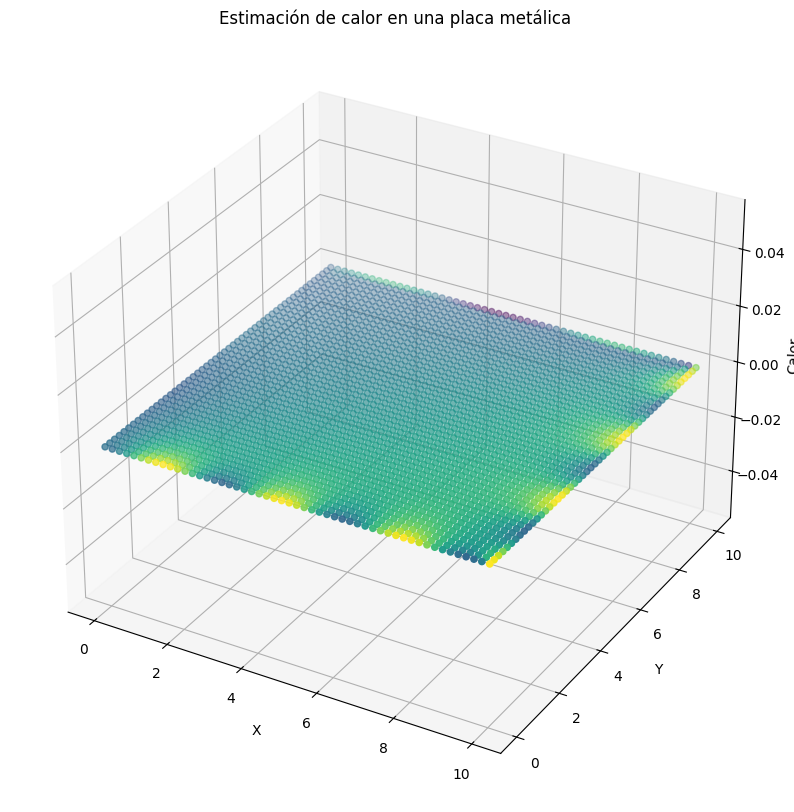

In [14]:
# Visualizamos en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eje_x, eje_y, c=calor_con_bordes, cmap='viridis', marker='o') 

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Calor")
ax.set_title("Estimación de calor en una placa metálica")
plt.show()

#### Visualización 2: el calor es la altura

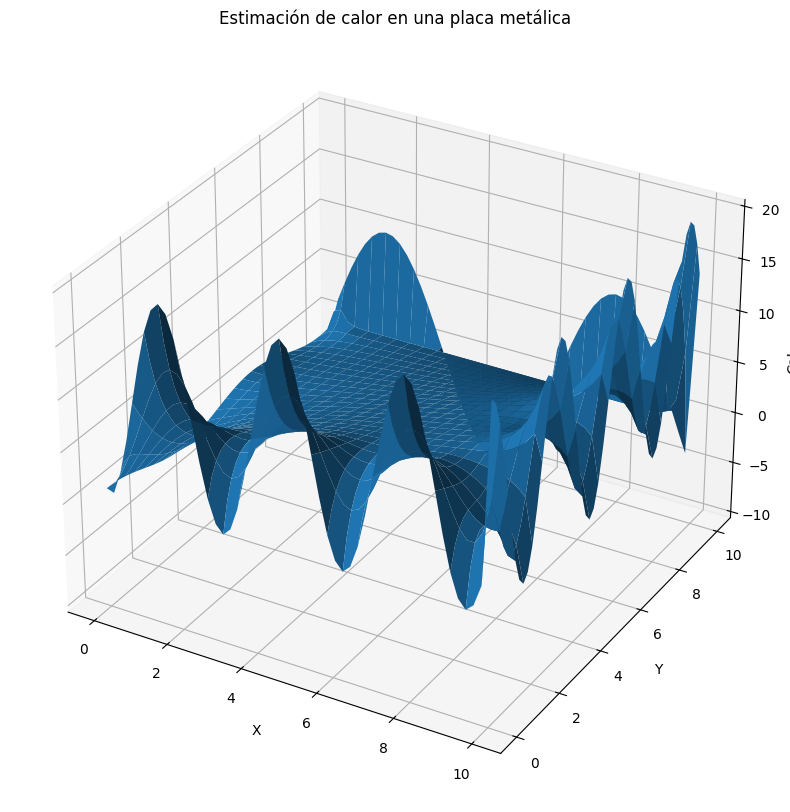

In [19]:
# Este es el vector solución (sustituir por lo que regresa el método de gradiente conjugado)
x = eje_x + eje_y

# Visualizamos en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(eje_x, eje_y, calor_con_bordes) 

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Calor")
ax.set_title("Estimación de calor en una placa metálica")
plt.show()